In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-06-19 15:45:08 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-06-19 15:45:08 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-06-19 15:45:08 __main__ INFO     transformers.__version__='4.41.2'


In [3]:
from nnsight import LanguageModel
from src.models import ModelandTokenizer

mt = ModelandTokenizer(
    model_key="meta-llama/Meta-Llama-3-8B",
    torch_dtype=torch.float16,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-06-19 15:45:10 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

2024-06-19 15:45:14 src.models INFO     loaded model </home/local_arnab/Codes/saved_model_weights/meta-llama/Meta-Llama-3-8B> | size: 15316.516 MB | dtype: torch.float16 | device: cuda:0


In [4]:
from src.dataset import InContextQuery
from src.functional import find_token_range, prepare_input, predict_next_token


icq = InContextQuery(
    subject="The Space Needle",
    cf_description="the capital of Japan",
    answer = "Tokyo",
)

icq.query

'Assume an alternative universe where The Space Needle is in the capital of Japan. In that universe, The Space Needle is located in the city of'

In [5]:
inputs = prepare_input(
    prompts = icq.query, 
    tokenizer=mt, 
    return_offsets_mapping=True
)

subj_range = find_token_range(
    string=icq.query,
    substring=icq.subject,
    tokenizer=mt.tokenizer,
    occurrence=-1,
    offset_mapping=inputs["offset_mapping"][0],
)

print(subj_range) 
[
    mt.tokenizer.decode(t) 
    for t in inputs["input_ids"][0][subj_range[0]:subj_range[1]]
]

(21, 24)


[' The', ' Space', ' Needle']

In [6]:
predict_next_token(
    mt = mt, 
    inputs=inputs,
)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[[PredictedToken(token=' Tokyo', prob=0.27447590231895447, token_id=tensor(27286, device='cuda:0')),
  PredictedToken(token=' Nag', prob=0.07104411721229553, token_id=tensor(30162, device='cuda:0')),
  PredictedToken(token=' Osaka', prob=0.06468640267848969, token_id=tensor(88085, device='cuda:0')),
  PredictedToken(token=' Kyoto', prob=0.06418301165103912, token_id=tensor(82122, device='cuda:0')),
  PredictedToken(token=' N', prob=0.0346241369843483, token_id=tensor(452, device='cuda:0'))]]

In [7]:
inputs.input_ids.shape

torch.Size([1, 30])

In [53]:
import baukit
import types
from src.hooking.llama_attention import LlamaAttentionPatcher, AttentionEdge
mt.reset_forward()

module_name = mt.attn_module_name_format.format(12)
attn_module = baukit.get_module(
    mt._model,
    module_name
)

cache_attn_matrices = {}

attn_module.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=module_name,
        save_attn_matrices_for=[5,10],
        attn_matrices=cache_attn_matrices,
        cut_attn_edges={
            5: [AttentionEdge(11, 9), AttentionEdge(14, 9)]
        }
    ),
    attn_module
)

# mt.reset_forward()

predict_next_token(
    mt = mt, 
    inputs=inputs,
)

# output = mt._model(**inputs)

[[PredictedToken(token=' Tokyo', prob=0.27295517921447754, token_id=tensor(27286, device='cuda:0')),
  PredictedToken(token=' Nag', prob=0.07065049558877945, token_id=tensor(30162, device='cuda:0')),
  PredictedToken(token=' Osaka', prob=0.06483253836631775, token_id=tensor(88085, device='cuda:0')),
  PredictedToken(token=' Kyoto', prob=0.06432800740003586, token_id=tensor(82122, device='cuda:0')),
  PredictedToken(token=' N', prob=0.03497452661395073, token_id=tensor(452, device='cuda:0'))]]

In [54]:
cache_attn_matrices[5].shape

torch.Size([1, 30, 30])

2024-06-19 15:55:51 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f8b24bfac50>


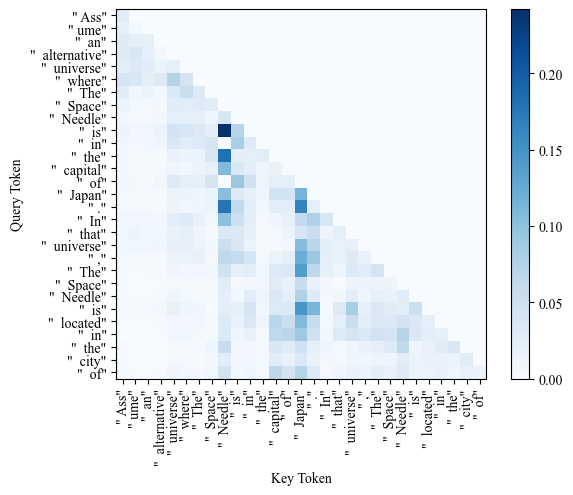

In [55]:
from src.plotting import visualize_attn_matrix

visualize_attn_matrix(
    attn_matrix=cache_attn_matrices[5].squeeze().cpu().detach().numpy(),
    tokens = [mt.tokenizer.decode(t) for t in inputs["input_ids"][0]],
    remove_eos=mt.tokenizer.bos_token
)